**Importing libraries**

In [1]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.optimize import curve_fit
from lmfit.models import LinearModel
from lmfit.models import GaussianModel
from lmfit import Parameters
import time
import corner
import linmix
from datetime import datetime

**Capturing name of the PC**

In [2]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [3]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if (PC_name_str == 'arc10'or PC_name_str == 'science11' or 
        PC_name_str == 'science10'):
    cores = 42        
#     cores = multi.cpu_count()
    
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

arc10
42


**Defining constants**

In [4]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [5]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [6]:
%%time
z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = '../Data/'
greater_than = 11.25
df_gal = pd.read_csv(data_address + f'massive_galaxies_10_{greater_than}.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
df_gal.describe()

CPU times: user 173 ms, sys: 28.4 ms, total: 201 ms
Wall time: 259 ms


,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],host,dist[kpc/h],vx[km/s],vy[km/s],vz[km/s]
count,93097.000000,93097.000000,93097.000000,9.309700e+04,93097.000000,93097.000000,93097.000000,93097.000000,93097.000000
mean,325576.133087,322500.028738,320613.762863,3.993206e+11,36294.172057,49.532974,0.763965,0.349477,-0.509183
std,184863.273960,182799.587421,183249.915097,3.995129e+11,21403.382524,179.779705,351.345586,343.572230,328.125457
min,1.864417,10.164207,0.260974,1.800010e+11,0.000000,0.000000,-2896.388700,-2323.086700,-2275.444800
25%,163866.950000,166201.380000,162514.560000,2.161480e+11,15329.000000,0.000000,-219.363920,-215.157970,-201.740720
50%,332449.620000,329260.160000,319925.780000,2.784900e+11,41555.000000,0.000000,-2.822351,2.646382,-3.028148
75%,483949.000000,475466.120000,478698.410000,4.192930e+11,57237.000000,0.000000,216.770710,214.257250,200.506210
max,639996.190000,639980.940000,639993.120000,1.077460e+13,57237.000000,2471.570000,2423.330800,3048.129900,2638.449000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for galaxies**

In [7]:
%%time

df_gal_temp = df_gal.copy()

df_gal_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_gal_temp['x[kpc/h]'] = df_gal['x[kpc/h]'] + (640000 * i)
            df_gal_temp['y[kpc/h]'] = df_gal['y[kpc/h]'] + (640000 * j)
            df_gal_temp['z[kpc/h]'] = df_gal['z[kpc/h]'] + (640000 * k)

            df_gal_big = df_gal_big.append(df_gal_temp)

df_gal_big.describe()

CPU times: user 2.61 s, sys: 4.9 s, total: 7.52 s
Wall time: 7.5 s


,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],host,dist[kpc/h],vx[km/s],vy[km/s],vz[km/s]
count,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06
mean,9.655761e+05,9.625000e+05,9.606138e+05,3.993206e+11,3.629417e+04,4.953297e+01,7.639653e-01,3.494774e-01,-5.091831e-01
std,5.542931e+05,5.536083e+05,5.537571e+05,3.995109e+11,2.140327e+04,1.797788e+02,3.513438e+02,3.435705e+02,3.281238e+02
min,1.864417e+00,1.016421e+01,2.609741e-01,1.800010e+11,0.000000e+00,0.000000e+00,-2.896389e+03,-2.323087e+03,-2.275445e+03
25%,4.839490e+05,4.754661e+05,4.786984e+05,2.161480e+11,1.532900e+04,0.000000e+00,-2.193639e+02,-2.151580e+02,-2.017407e+02
50%,9.724496e+05,9.692602e+05,9.599258e+05,2.784900e+11,4.155500e+04,0.000000e+00,-2.822351e+00,2.646382e+00,-3.028148e+00
75%,1.443867e+06,1.446201e+06,1.442515e+06,4.192930e+11,5.723700e+04,0.000000e+00,2.167707e+02,2.142572e+02,2.005062e+02
max,1.919996e+06,1.919981e+06,1.919993e+06,1.077460e+13,5.723700e+04,2.471570e+03,2.423331e+03,3.048130e+03,2.638449e+03


**Reading clusters dataset**

In [8]:
df_clusters_orig = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

df_clusters_orig.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6080.000000,6080.000000,6080.000000,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,326416.401838,322055.402286,321308.240244,6.356245e+13,2.109102,-1.647297,-4.296055
std,186021.550694,182650.899538,183665.854310,4.851698e+13,316.064539,306.226537,286.454388
min,19.163288,152.653880,87.370949,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,160978.575000,164793.430000,161863.925000,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,338884.565000,333274.345000,322110.075000,4.801630e+13,-3.619450,1.969450,-8.055475
75%,486227.747500,473556.765000,478893.610000,6.945502e+13,206.816750,207.755750,181.532000
max,639887.560000,639933.380000,639848.380000,7.438200e+14,1197.640000,1164.960000,1201.260000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for clusters**

In [9]:
df_clusters_temp = df_clusters_orig.copy()

df_clusters_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_clusters_temp['x[kpc/h]'] = df_clusters_orig['x[kpc/h]'] + (640000 * i)
            df_clusters_temp['y[kpc/h]'] = df_clusters_orig['y[kpc/h]'] + (640000 * j)
            df_clusters_temp['z[kpc/h]'] = df_clusters_orig['z[kpc/h]'] + (640000 * k)

            df_clusters_big = df_clusters_big.append(df_clusters_temp)

df_clusters_big.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,1.641600e+05,1.641600e+05,1.641600e+05,1.641600e+05,164160.000000,164160.000000,164160.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,5.546773e+05,5.535561e+05,5.538918e+05,4.851314e+13,316.039508,306.202286,286.431703
min,1.916329e+01,1.526539e+02,8.737095e+01,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,4.863366e+05,4.736062e+05,4.789278e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.440918e+06,1.444771e+06,1.441655e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.919888e+06,1.919933e+06,1.919848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Extracting clusters present in central region from 640 h$^{-1}$Mpc to 1280 h$^{-1}$Mpc**

In [10]:
low_bound = 640000
upp_bound = 640000 * 2  #128000

df_clusters_center = df_clusters_big[(df_clusters_big['x[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['x[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['y[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['y[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['z[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['z[kpc/h]'] < upp_bound)]

df_clusters_center.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6.080000e+03,6.080000e+03,6.080000e+03,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,1.860216e+05,1.826509e+05,1.836659e+05,4.851698e+13,316.064539,306.226537,286.454388
min,6.400192e+05,6.401527e+05,6.400874e+05,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,8.009786e+05,8.047934e+05,8.018639e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.126228e+06,1.113557e+06,1.118894e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.279888e+06,1.279933e+06,1.279848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Creating mass bin for clusters**

In [11]:
def clus_binner(min_mass, max_mass):
    
    df_clus_bin = df_clusters_center[(df_clusters_center['m500c[Msol/h]'] > min_mass) &
                                     (df_clusters_center['m500c[Msol/h]'] < max_mass)]
    
    return df_clus_bin

**Adding galaxy pads at the edges of central cluster region**

In [12]:

def edge_pads_adder(clus_cube_size):
       
    low_bound =  640000    - (clus_cube_size//2)
    upp_bound = (640000*2) + (clus_cube_size//2)
    
#     print(low_bound, upp_bound)
    
    df_gal_padded = df_gal_big[(df_gal_big['x[kpc/h]'] >= low_bound) & 
                               (df_gal_big['x[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['y[kpc/h]'] >= low_bound) & 
                               (df_gal_big['y[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['z[kpc/h]'] >= low_bound) & 
                               (df_gal_big['z[kpc/h]'] <= upp_bound)]
            
    return df_gal_padded
    

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [13]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.5938062370014


2.380620866668027

In [14]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

**Calculating mean density of the simulation box for Eq. 1**

In [15]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal_big.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    sim_box_size = 640000 * 3
    gals_in_cell = np.zeros((sim_box_size//cell_size, sim_box_size//cell_size, sim_box_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    delta_gal_mean = np.mean(gals_in_cell)
    
    return delta_gal_mean

**Calculating Overdensity field for Eq. 1**

In [16]:
def overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, clus_cube_size, df_gal_padded):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal_padded[(df_gal_padded['x[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                  (df_gal_padded['x[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x - (clus_cube_size//2))
    df_gal_cube['y[kpc/h]'] -= (clus_y - (clus_cube_size//2))
    df_gal_cube['z[kpc/h]'] -= (clus_z - (clus_cube_size//2))

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] // cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] // cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] // cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
#     df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'], df_gal_cube['y[kpc/h]'], df_gal_cube['z[kpc/h]']))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
    
    delta_gal_error = gals_in_cell_avg_err/delta_gal_mean  
    
    #smoothing the overdensity of galaxies
#     delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [17]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [18]:
def clus_velocity_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, vel_terms, sigma_in_pix, 
                       clus_cube_size, df_gal_padded):
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, 
                                          clus_cube_size, df_gal_padded)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(h*1e3)) / denom
    
    dist = np.cbrt(denom)
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


**Calculating sigma for smoothing**

In [19]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

In [20]:
def lmfit_func(x_values, y_values, errors = None):
    model = LinearModel()
    
    fit_params = model.guess(y_values, x = x_values)
#     fit_params['intercept'].set(value = 0, vary = False)
    
    if errors is None:
        errors = np.ones(x_values.shape)
    
    result = model.fit(y_values, 
                       params = fit_params, 
                       x = x_values, weights = 1/errors)
    
#     print(result.fit_report())
    

    return result  

# param_x_lmfit = lmfit_func(df_clusters_est_err['vx[km/s]'], 
#                            df_clusters_est_err['vx_est[km/s]'], 
#                            df_clusters_est_err['vx_est_err[km/s]'])
# print(param_x_lmfit.params['intercept'].value, param_x_lmfit.params['intercept'].stderr)
# print(np.random.normal(param_x_lmfit.params['intercept'].value, param_x_lmfit.params['intercept'].stderr, 10))

In [21]:
def linmix_func(x_values, y_values, errors):
    t_i = time.time()

    lm = linmix.LinMix(x_values, y_values, ysig = errors
#                        , nchains = 1
#                        , parallelize = False
                      )
    lm.run_mcmc(silent = True, maxiter = 10000)

    print(time.time() - t_i)
    print(len(lm.chain))
    
#     index_90 = int(len(lm.chain) * 0.9)
    
    return lm.chain
#     return lm.chain['beta'][-index_90:].mean(), lm.chain['alpha'][-index_90:].mean()

In [38]:
def scipy_curve_fit_func(x_values, y_values, y_errors):
    
    def linear_func(x, m, c):
        return m*x + c
    
    param = curve_fit(linear_func, x_values, y_values, sigma = y_errors, 
              absolute_sigma = True)
    
    return param

In [23]:
param = scipy_curve_fit_func(bins_centers_log, 
                             clus_mass_bins_results_all['Slope - Vlos'],
                             clus_mass_bins_results_all['Error - Slope - Vlos'])

slope, intercept = param[0]
slope_err, intercept_err = np.sqrt(param[1][0,0]), np.sqrt(param[1][1,1])

print('Slope: ', round(param[0][0], 2), ' +- ', round(np.sqrt(param[1][0, 0]), 3))
print('\n')
print('Slope: ', slope, ' +- ', slope_err)
print('Intercept: ', intercept, ' +- ', intercept_err)


NameError: name 'bins_centers_log' is not defined

In [ ]:
param = scipy_curve_fit_func(bins_centers_log, 
                             clus_mass_bins_results_all['Slope - Vlos'],
                             clus_mass_bins_results_all['Error - Slope - Vlos'])

slope, intercept = param[0]
slope_err, intercept_err = np.sqrt(param[1][0,0]), np.sqrt(param[1][1,1])

print('Slope: ', round(param[0][0], 2), ' +- ', round(np.sqrt(param[1][0, 0]), 3))
print('\n')
print('Slope: ', slope, ' +- ', slope_err)
print('Intercept: ', intercept, ' +- ', intercept_err)


In [ ]:
from astropy.modeling import models, fitting

fit = fitting.LevMarLSQFitter()
line_init = models.Linear1D()

fitted_line = fit(line_init, bins_centers_log, 
                 clus_mass_bins_results_all['Slope - Vlos'],
                 weights = 1/clus_mass_bins_results_all['Error - Slope - Vlos'])

fitted_line.slope
fitted_line.intercept
np.sqrt(fit.fit_info['param_cov'])

**Plotting the scatter plots & histograms for assesment of velocity estimates**

In [24]:
print(datetime.now())
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi*1.5, 
                     figsize = (9, 4),
                     facecolor=(1, 1, 1))
    
    cluster_jump = 1
    x_pos_text = 0.37
    text_font_size = 8

    plt.subplot(1,2,1)
    plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], 
                 df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_err[km/s]'][::cluster_jump], 
                 fmt='.', ecolor='C6')        
    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, est}$ (km/s)')
    low_lim, high_lim = -2000, 2000
    plt.gca().set_xticks(range(low_lim, high_lim + 1, 1000))
    plt.gca().set_yticks(range(low_lim, high_lim + 1, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('V$_{\mathrm{x}}$')
    
    
    plt.text(x_pos_text, 0.18, 
             f'Clusters: {len(df_clusters_est_err)} ({len(df_clusters_est_err)//cluster_jump} shown)', 
             transform=plt.gca().transAxes, fontsize = text_font_size)
    
    
    x_range = np.arange(low_lim, high_lim+1, 5)   
    
    def fit_func(x, m, c):
        return m*x + c
    

    param_x_lmfit = lmfit_func(df_clusters_est_err['vx[km/s]'], 
                                   df_clusters_est_err['vx_est[km/s]'], 
                                   df_clusters_est_err['vx_est_err[km/s]'])
    
    residuals_x = (df_clusters_est_err['vx_est[km/s]'] - 
             fit_func(df_clusters_est_err['vx[km/s]'], param_x_lmfit.params['slope'].value, 
             param_x_lmfit.params['intercept'].value))
                      
    
    plt.text(0.05, 0.75, 
             f"Scatter: {round(np.std(residuals_x), 1)} km/s", 
             transform=plt.gca().transAxes, fontsize = text_font_size)
    
    
    plt.plot(x_range, fit_func(x_range, param_x_lmfit.params['slope'].value, 
             param_x_lmfit.params['intercept'].value), 
             label = 'Linear fit - lmfit', c = 'C2')
    
    plt.text(x_pos_text, 0.12, 
             f"Slope: {param_x_lmfit.params['slope'].value.round(2)} $\pm$ {param_x_lmfit.params['slope'].stderr.round(2)}", 
             transform=plt.gca().transAxes, fontsize = text_font_size)
#     plt.text(x_pos_text, 0.06, 
#              f"Intercept: {param_x_lmfit.params['intercept'].value} km/s", 
#              transform=plt.gca().transAxes, fontsize = 9)
    plt.text(x_pos_text, 0.06, 
             f"Intercept: {round(param_x_lmfit.params['intercept'].value, 2)} $\pm$ {round(param_x_lmfit.params['intercept'].stderr, 2)} km/s", 
             transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, 
             ls = 'dashed')
    plt.legend(fontsize = text_font_size)

    
    plt.subplot(1,2,2)
    
    plt.errorbar(df_clusters_est_err['v_los[km/s]'][::cluster_jump], 
                 df_clusters_est_err['v_los_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['v_los_est_err[km/s]'][::cluster_jump], 
                 alpha = 0.2, markeredgewidth = 0, markersize = 8,
                 fmt='.', ecolor='C6')        
#     plt.scatter(df_clusters_est_err['v_los[km/s]'][::cluster_jump], 
#                  df_clusters_est_err['v_los_est[km/s]'][::cluster_jump], 
# #                  yerr = df_clusters_est_err['v_los_est_err[km/s]'][::cluster_jump], 
#                  alpha = 0.5, edgecolors = 'white', s = 8)
    
    plt.xlabel('V$_\mathrm{los, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{los, est}$ (km/s)')
#     low_lim, high_lim = -1000, 1000
    low_lim, high_lim = -1500, 1500
    plt.gca().set_xticks(range(low_lim, high_lim + 1, high_lim//2))
    plt.gca().set_yticks(range(low_lim, high_lim + 1, high_lim//2))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.suptitle(f'Sphere radius: {clus_cube_size//2e3} ' + 'h$^{-1}$Mpc |' + 
                 f' Cell: {cell_size//1e3}' + ' h$^{-1}$Mpc |' +
                 f' Galaxies: ' + "{:.1e}".format(len(df_gal)))
    
    x_pos_text = 0.37
    plt.text(x_pos_text, 0.12, 
             f'Clusters: {len(df_clusters_est_err)} ({len(df_clusters_est_err)//cluster_jump} shown)', 
             transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
    print('Fitting with lmfit...')
    param_los_lmfit = lmfit_func(df_clusters_est_err['v_los[km/s]'], 
                                   df_clusters_est_err['v_los_est[km/s]']
                                 , df_clusters_est_err['v_los_est_err[km/s]']
                                )
    
#     param_los_linmix = linmix_func(df_clusters_est_err['v_los[km/s]'], 
#                                    df_clusters_est_err['v_los_est[km/s]']
#                                  , df_clusters_est_err['v_los_est_err[km/s]'])
    
    
#     print('Fitting with linmix...')
#     param_los_linmix = linmix_func(df_clusters_est_err['v_los[km/s]'], 
#                                df_clusters_est_err['v_los_est[km/s]']
#                                , df_clusters_est_err['v_los_est_err[km/s]'])
    
#     x_range = np.arange(low_lim, high_lim+1, 5e8)                    


#     index_90 = int(len(param_los_linmix) * 0.9)
    
#     linmix_slope = param_los_linmix['beta'][-index_90:].mean()
#     linmix_intercept = param_los_linmix['alpha'][-index_90:].mean()
#     linmix_scatter = np.sqrt(param_los_linmix['sigsqr'][-index_90:]).mean()
    
    linmix_slope = param_los_lmfit.params['slope'].value.round(3)
    linmix_intercept = param_los_lmfit.params['intercept'].value.round(2)
    linmix_scatter = 0
    
    plt.text(0.05, 0.65, 
             f"Scatter: {round(linmix_scatter, 1)} km/s", 
             transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
    plt.plot(x_range, fit_func(x_range, param_los_lmfit.params['slope'].value, 
             param_los_lmfit.params['intercept'].value), 
             label = 'Linear fit - lmfit', c = 'C2')
    
    
    
    
#     plt.plot(x_range, fit_func(x_range, linmix_slope, linmix_intercept), 
#              label = 'Linear fit - linmix', c = 'C4', ls = 'dashdot')    
    
    #     plt.text(x_pos_text, 0.15, 
#              f"Slope: {param_los_lmfit.params['slope'].value.round(2)} $\pm$ {param_los_lmfit.params['slope'].stderr.round(2)} (lmfit),  {param_los_linmix[0].round(2)} (linmix)", 
#              transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
    
    plt.text(x_pos_text, 0.12, 
             f"Slope: {param_los_lmfit.params['slope'].value.round(2)} $\pm$ {param_los_lmfit.params['slope'].stderr.round(2)}", 
             transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.text(x_pos_text, 0.06, 
             f"Intercept: {round(param_los_lmfit.params['intercept'].value, 2)} $\pm$ {round(param_los_lmfit.params['intercept'].stderr, 2)} km/s", 
             transform=plt.gca().transAxes, fontsize = text_font_size)
    

    
    
#     plt.text(x_pos_text, 0.08, 
#              f"Slope: {param_los_lmfit.params['slope'].value.round(2)} $\pm$ " + 
#              f"{param_los_lmfit.params['slope'].stderr.round(2)} (lmfit),  " + 
#              f"{linmix_slope.round(2)} (linmix)", 
#              transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
#     plt.text(x_pos_text, 0.04, 
#              f"Intercept: {round(param_los_lmfit.params['intercept'].value, 2)} $\pm$ " + 
#              f"{round(param_los_lmfit.params['intercept'].stderr, 2)} (lmfit), " + 
#              f"{linmix_intercept.round(2)} (linmix)", 
#              transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    

    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, 
             ls = 'dashed')
    plt.legend(loc = 'upper left', fontsize = text_font_size)
    
    x = 1
#     plt.title('V$_{\mathrm{los}}$ - ' + f'{x}x enhanced')
    plt.title('V$_{\mathrm{los}}$')
    
    slope_dist = np.random.normal(param_los_lmfit.params['slope'].value, 
                                  param_los_lmfit.params['slope'].stderr, 10000)
    intercept_dist = np.random.normal(param_los_lmfit.params['intercept'].value, 
                                      param_los_lmfit.params['intercept'].stderr, 
                                      10000)
    
    v_los_est_err = np.zeros(x_range.size)
    for i in range(x_range.size):
        v_los_est = (slope_dist * x_range[i]) + intercept_dist
        v_los_est_err[i] = np.std(v_los_est)
    
    plt.fill_between(x_range, 
             fit_func(x_range, param_los_lmfit.params['slope'].value, 
             param_los_lmfit.params['intercept'].value) + (v_los_est_err * x), 
             fit_func(x_range, param_los_lmfit.params['slope'].value , 
             param_los_lmfit.params['intercept'].value) - (v_los_est_err * x), 
             alpha = 0.2)


    plt.tight_layout()
    
#     os.system(f'mkdir Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}')
    plt.savefig(f'Plots/GT_{greater_than}/{cell_size}/v_scatter_hist_{cell_size}_{len(df_clusters_est_err)}_{clus_min_mass}_{clus_max_mass}.png')
    plt.close()
#     plt.show()


#     combined = np.transpose(np.vstack((param_los_linmix['beta'][-index_90:], 
#                                        param_los_linmix['alpha'][-index_90:],
#                                        np.sqrt(param_los_linmix['sigsqr'])[-index_90:])))


#     corner.corner(combined, bins = 20, labels = ['Slope', 'Intercept', 'Scatter'], 
#                   levels=[1-np.exp(-0.5), 1-np.exp(-2)], 
#                   quantiles = ([0.16, 0.84]),
#                   verbose = True, title_fmt = '.2f', 
#                   color = 'brown', show_titles=True);
    
#     plt.gcf().patch.set_facecolor('white')
#     plt.text(-0.3, 2.7, f'Cell size: {int(cell_size/1e3)} Mpc', fontsize = 18, 
#              transform=plt.gca().transAxes)
    
#     plt.savefig(f'Plots/corner_{cell_size}_{clus_cube_size_actual}_{hollow_depth}.png', dpi = dpi)
#     plt.close()
    
    return linmix_slope, linmix_intercept, linmix_scatter

2021-07-27 17:17:20.739513


In [25]:
print(datetime.now())

2021-07-27 17:17:24.181132


**Examining the effects of cluster cube & cell sizes variation on velocity estimates**

In [43]:
%%time

print(datetime.now())

b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 
                                'Cube Size Set', 'Clusters', 'Lower lim', 'Upper lim',
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])

clus_mass_bins_log = np.arange(13.50, 14.31, 0.2)
clus_mass_bins_log = np.append(clus_mass_bins_log, 14.9)
clus_mass_bins_linear = 10**clus_mass_bins_log
# clus_mass_bins = np.array([3e13, 5e13, 7e13, 9e13, 1e14, 2e14, 7e14])
# clus_mass_bins = np.geomspace(3e13, 7e14, num = 4)
n_clusters = 145

# clus_cube_sizes = [400000, 500000, 60000]
clus_cube_size = 500000
for i, clus_min_mass in enumerate(clus_mass_bins_linear[:-1]):
    for cell_size in [10000]:                       #h^-1 kpc, size of pixel or cell
        
        t = time.time()
        
        clus_max_mass = clus_mass_bins_linear[i+1]
        
        print(cell_size, clus_cube_size, clus_min_mass, clus_max_mass)
                
        no_of_cells = clus_cube_size//cell_size
        
        clus_cube_size_actual = clus_cube_size
        
        if no_of_cells % 2 != 0:
            clus_cube_size = clus_cube_size - (cell_size//2)
        
        sigma_in_pix = sigma_calc(cell_size)

        df_gal_padded = edge_pads_adder(clus_cube_size)
        
        df_clus_bin = clus_binner(clus_min_mass, clus_max_mass)
        df_clus_bin = df_clus_bin.sample(n = n_clusters, replace = False, 
                                               random_state = 0)  

        delta_gal_mean = delta_gal_mean_func(cell_size)

        vel_terms = vel_terms_calc(cell_size, clus_cube_size)
        
        no_of_clus = len(df_clus_bin)

        clus_param = list(zip(df_clus_bin['x[kpc/h]'], df_clus_bin['y[kpc/h]'], df_clus_bin['z[kpc/h]'], 
                              [delta_gal_mean]*no_of_clus, [cell_size]*no_of_clus, 
                              [vel_terms]*no_of_clus, [sigma_in_pix]*no_of_clus,
                              [clus_cube_size]*no_of_clus, [df_gal_padded]*no_of_clus))

        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        df_clusters_est_err = df_clus_bin.copy()
        
        

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x[kpc/h]']**2 +
                                                      df_clusters_est_err['y[kpc/h]']**2 +
                                                      df_clusters_est_err['z[kpc/h]']**2)
        
        
        df_clusters_est_err['v_los[km/s]'] = (((df_clusters_est_err['vx[km/s]'] * df_clusters_est_err['x[kpc/h]']) +
                                               (df_clusters_est_err['vy[km/s]'] * df_clusters_est_err['y[kpc/h]']) +
                                               (df_clusters_est_err['vz[km/s]'] * df_clusters_est_err['z[kpc/h]'])) /
                                                df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                                                             (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                                                             (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
#         linmix_slope, linmix_intercept, linmix_scatter = plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual)
        
#         clear_output(wait=True)
        
                
#         param_los_lmfit = lmfit_func(df_clusters_est_err['v_los[km/s]'], 
#                                      df_clusters_est_err['v_los_est[km/s]']
#                                    , df_clusters_est_err['v_los_est_err[km/s]']
#                                   )
        
        param_los_scipy = scipy_curve_fit_func(df_clusters_est_err['v_los[km/s]'], 
                                     df_clusters_est_err['v_los_est[km/s]']
                                   , df_clusters_est_err['v_los_est_err[km/s]'])




        
        clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
                'Act Cube Size': clus_cube_size_actual,
                'Cube Size Set': clus_cube_size,
                'Clusters': no_of_clus,
                                                                
                'Lower lim': clus_min_mass,
                'Upper lim': clus_max_mass,                                                        
                                                                                 
                'Slope - Vlos': round(param_los_scipy[0][0], 3),  
                'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
                'Intercept - Vlos': round(param_los_scipy[0][1], 3),
                'Scatter - Vlos': 'Not-calculated',
               
                                                                               }, 
                ignore_index=True)
        
        clus_cube_size = clus_cube_size_actual
        
        print('Time taken:', time.time() - t)
        print('\n')
        

2021-07-27 17:51:02.800488
10000 500000 31622776601683.793 50118723362727.15
Time taken: 16.901106595993042


10000 500000 50118723362727.15 79432823472427.89
Time taken: 16.770930528640747


10000 500000 79432823472427.89 125892541179416.11
Time taken: 16.86324691772461


10000 500000 125892541179416.11 199526231496886.66
Time taken: 17.311283588409424


10000 500000 199526231496886.66 794328234724282.1
Time taken: 18.180309295654297


CPU times: user 42.4 s, sys: 27.1 s, total: 1min 9s
Wall time: 1min 26s


In [44]:
clus_mass_bins_results

,Cell Size,Act Cube Size,Cube Size Set,Clusters,Lower lim,Upper lim,Slope - Vlos,Error - Slope - Vlos,Intercept - Vlos,Scatter - Vlos
0,10000,500000,500000,145,3.162278e+13,5.011872e+13,0.679,0.056,68.848,Not-calculated
1,10000,500000,500000,145,5.011872e+13,7.943282e+13,0.768,0.056,62.789,Not-calculated
2,10000,500000,500000,145,7.943282e+13,1.258925e+14,0.758,0.059,55.256,Not-calculated
3,10000,500000,500000,145,1.258925e+14,1.995262e+14,0.842,0.058,65.798,Not-calculated
4,10000,500000,500000,145,1.995262e+14,7.943282e+14,0.856,0.073,59.934,Not-calculated


In [45]:
clus_mass_bins_results.to_csv(f'clus_mass_bins_results_{greater_than}_{cell_size}_{n_clusters}_lmfit.csv', 
                              sep = '\t')



In [41]:
clus_mass_bins_results.to_csv(f'clus_mass_bins_results_{greater_than}_{cell_size}_all_lmfit.csv', 
                              sep = '\t')



In [46]:
clus_mass_bins_results_145 = pd.read_csv(f'clus_mass_bins_results_{greater_than}_10000_145_lmfit.csv', 
                              sep = '\t', index_col = 0)
clus_mass_bins_results_145


,Cell Size,Act Cube Size,Cube Size Set,Clusters,Lower lim,Upper lim,Slope - Vlos,Error - Slope - Vlos,Intercept - Vlos,Scatter - Vlos
0,10000,500000,500000,145,3.162278e+13,5.011872e+13,0.679,0.056,68.848,Not-calculated
1,10000,500000,500000,145,5.011872e+13,7.943282e+13,0.768,0.056,62.789,Not-calculated
2,10000,500000,500000,145,7.943282e+13,1.258925e+14,0.758,0.059,55.256,Not-calculated
3,10000,500000,500000,145,1.258925e+14,1.995262e+14,0.842,0.058,65.798,Not-calculated
4,10000,500000,500000,145,1.995262e+14,7.943282e+14,0.856,0.073,59.934,Not-calculated


In [42]:
clus_mass_bins_results_all = pd.read_csv(f'clus_mass_bins_results_{greater_than}_10000_all_lmfit.csv', 
                              sep = '\t', index_col = 0)
clus_mass_bins_results_all


,Cell Size,Act Cube Size,Cube Size Set,Clusters,Lower lim,Upper lim,Slope - Vlos,Error - Slope - Vlos,Intercept - Vlos,Scatter - Vlos
0,10000,500000,500000,3261,3.162278e+13,5.011872e+13,0.734,0.011,65.449,Not-calculated
1,10000,500000,500000,1674,5.011872e+13,7.943282e+13,0.745,0.016,63.897,Not-calculated
2,10000,500000,500000,723,7.943282e+13,1.258925e+14,0.798,0.026,64.311,Not-calculated
3,10000,500000,500000,277,1.258925e+14,1.995262e+14,0.794,0.044,70.668,Not-calculated
4,10000,500000,500000,145,1.995262e+14,7.943282e+14,0.856,0.073,59.934,Not-calculated


In [49]:
def lmfit_gaussian_fit_func(x_values, y_values):
    
    gaussian_model = GaussianModel()
    
    fit_params = gaussian_model.guess(y_values, x = x_values)
    
    result = gaussian_model.fit(y_values, 
                                params = fit_params,
                                x = x_values)
    
    result.plot_fit(data_kws = {'ms': 0}, fit_kws = {'color': 'r'})
    
    return result

# mass_bin_linmix_145['beta']
# mass_bin_linmix_145['alpha']

In [50]:
def plot_posterior(mass_bin_linmix_145, title):
    plt.figure(dpi = dpi)

    index_90 = int(len(mass_bin_linmix_145) * 0.95)

    hist_output = plt.hist(mass_bin_linmix_145['beta'][-index_90:], bins = 100,
                           range = (-2, 2), label = 'histogram');

    x_val = hist_output[1][:-1] + (hist_output[1][1] - hist_output[1][0])
    y_val = hist_output[0]

    fit = lmfit_gaussian_fit_func(x_val, y_val)

    plt.xlabel('Slope')
    plt.ylabel('Count')
    plt.title(f'Distribution of Posterior | {title}')

    round(fit.params['center'].value, 2)

    x_pos_text = 0.05
    plt.text(x_pos_text, 0.8, 
                 f"$\mu$ = {round(fit.params['center'].value, 2)}", 
                 transform=plt.gca().transAxes)
    plt.text(x_pos_text, 0.75, 
                 f"$\sigma$ = {round(fit.params['sigma'].value, 2)}", 
                 transform=plt.gca().transAxes);

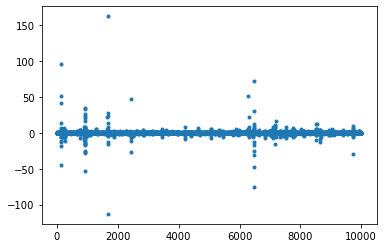

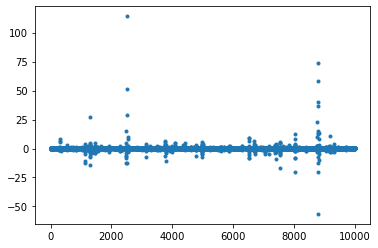

In [57]:
plt.plot(mass_bin_linmix_145['beta'], '.')
plt.figure()
plt.plot(mass_bin_linmix_all['beta'], '.')

5.124173402786255
10000
5.25896143913269
10000


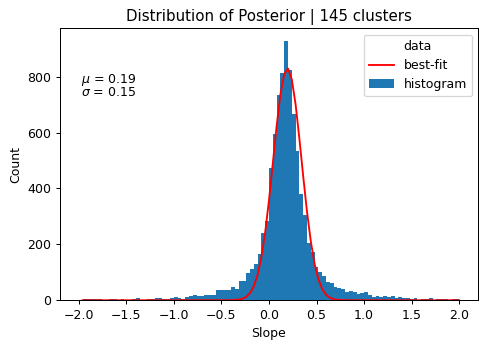

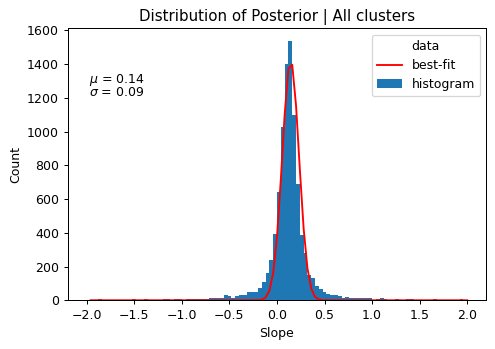

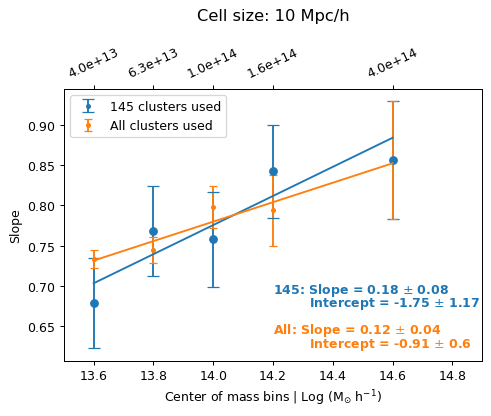

In [52]:
bins_centers_log = np.arange(13.6, 14.21, 0.2)
bins_centers_log = np.append(bins_centers_log, 14.6)


mass_bin_linmix_145 = linmix_func(bins_centers_log, 
                                  clus_mass_bins_results_145['Slope - Vlos'],
                                  clus_mass_bins_results_145['Error - Slope - Vlos'])

plot_posterior(mass_bin_linmix_145, title = '145 clusters')


mass_bin_linmix_all = linmix_func(bins_centers_log, 
                                  clus_mass_bins_results_all['Slope - Vlos'],
                                  clus_mass_bins_results_all['Error - Slope - Vlos'])

plot_posterior(mass_bin_linmix_all, title = 'All clusters')



plt.figure(dpi = dpi*1)

plt.errorbar(bins_centers_log, 
             clus_mass_bins_results_145['Slope - Vlos'],
             clus_mass_bins_results_145['Error - Slope - Vlos'],
             label = '145 clusters used', capsize = 5, fmt = '.')

plt.errorbar(bins_centers_log, 
             clus_mass_bins_results_all['Slope - Vlos'],
             clus_mass_bins_results_all['Error - Slope - Vlos'],
             label = 'All clusters used', capsize = 3, fmt = '.')

plt.legend()
# plt.xscale('log')
plt.xlabel('Center of mass bins | Log (M$_{\odot}$ h$^{-1}$)')
plt.ylabel('Slope')
plt.xlim(13.5, 14.9)




axes1 = plt.gca()
axes2 = axes1.twiny()

axes2.scatter(bins_centers_log, 
             clus_mass_bins_results_145['Slope - Vlos'])
plt.xlim(13.5, 14.9)

bins_centers_linear = 10**bins_centers_log
bins_centers_linear_str = ['{:.1e}'.format(i) for i in bins_centers_linear]

axes2.set_xticks(bins_centers_log)
axes2.set_xticklabels(bins_centers_linear_str, 
                      rotation = 25);


def linear_func(x, m, c):
        return m*x + c

mass_bin_scipy_145 = scipy_curve_fit_func(bins_centers_log, 
                             clus_mass_bins_results_145['Slope - Vlos'],
                             clus_mass_bins_results_145['Error - Slope - Vlos'])

slope_145, intercept_145 = mass_bin_scipy_145[0]
slope_err_145, intercept_err_145 = (np.sqrt(mass_bin_scipy_145[1][0,0]), 
                                   np.sqrt(mass_bin_scipy_145[1][1,1]))


plt.plot(bins_centers_log, 
         linear_func(bins_centers_log, slope_145, intercept_145))

x_pos_text = 0.5
text_font_size = 8

plt.text(x_pos_text, 0.25, 
             f"145: Slope = {round(slope_145, 2)} $\pm$ " + 
             f"{round(slope_err_145, 2)}", 
             transform=plt.gca().transAxes, color = 'C0', weight = 'bold')

plt.text(x_pos_text + 0.085, 0.20, 
             f"Intercept = {round(intercept_145, 2)} $\pm$ " + 
             f"{round(intercept_err_145, 2)}", 
             transform=plt.gca().transAxes, color = 'C0', weight = 'bold')




mass_bin_scipy_all = scipy_curve_fit_func(bins_centers_log, 
                             clus_mass_bins_results_all['Slope - Vlos'],
                             clus_mass_bins_results_all['Error - Slope - Vlos'])

slope_all, intercept_all = mass_bin_scipy_all[0]
slope_err_all, intercept_err_all = (np.sqrt(mass_bin_scipy_all[1][0,0]), 
                                   np.sqrt(mass_bin_scipy_all[1][1,1]))


plt.plot(bins_centers_log, 
         linear_func(bins_centers_log, slope_all, intercept_all))

plt.text(x_pos_text, 0.10, 
             f"All: Slope = {round(slope_all, 2)} $\pm$ " + 
             f"{round(slope_err_all, 2)}", 
             transform=plt.gca().transAxes, color = 'C1', weight = 'bold')

plt.text(x_pos_text + 0.085, 0.05, 
             f"Intercept = {round(intercept_all, 2)} $\pm$ " + 
             f"{round(intercept_err_all, 2)}", 
             transform=plt.gca().transAxes, color = 'C1', weight = 'bold');

plt.title('Cell size: 10 Mpc/h', fontsize = 13, pad = 55);


The fit below line can be used as there is systematic underestimation of true velocity if we use low mass clusters (Tanimura's optical ones) instead of high mass clusters (Planck's).

**14 July, 2021**  
A: This is 4 sigma detection of mass dependence slope which is quite significant. This has influence when optical or Planck catalogs are used.  
A: 10 mega parsecs cell size is better to have lower errors and lower scatter, hence better accuracy. But it also significantly underestimates the velocity by smoothing the density.

**7 July, 2021**  
A: The fit below line can be used as there is systematic underestimation of true velocity if we use low mass clusters (Tanimura's optical ones) instead of high mass clusters (Planck's).

**28 July, 2021**  
A: 3 sigma detection now (with lmfit). Errors increase with linmix compared to lmfit. **Task**: fit a Gaussian to slope posterior, remove outlying points $\pm$ 4 or 5 $\sigma$ and then fit a second Guassian. It may make it better. But probably it won't change the slope or errors.  

One reason of more error could be extra parameter of scatter of linmix. If you have extra parameter, you have more error. Since errors on points are so large, scatter must be (close to) zero here.  

B: **Task** Higher order moments (guess: skewness or kurtosis) can be calculated to check bin width bais coming may be due to the non-Gaussian wing near the tail.

A: There's a non-Gaussian tail in histograms. Gaussian fit is good on left side but not on right side. **Task** Try changing the bin width and do the fitting again. There is not a big bias but indeed there is a bit.

For paper, maybe we should code conservative fit of linmix but then mass dependence is not so statistically compelling.

**Task** Check if linmix is using the same definition of error (absolute or relative or half or double).

We should be able to trust simple chi square fitting (lmfit) with no scatter term.

Can there be some other affect (other than smoothing) that will mimic the mass dependence slope? Since we are trying to say people should be aware of a mass trend, they might say no, we don't have to because our 10 mega parsecs cell introduce this mass trend (guess because of smoothing).  

This mass dependence was hidden for other people. It is there, but the errors are so large that they never bothered, but people are not taking care of this error anyway. At least, Tanimura used straight.. the one is to one line. People use the the correlation parameter.. that's the scatter but it does not take into account the poisson error into the fit. We want to use the full regression with scatter, full error, and full mass dependence to propagate the error.  

**Task** Try 20 Mpc. Slopes should go even down. Fit will become more prominant because Poisson errors will go down.

In [54]:
print(datetime.now())
clus_mass_bins_results_5000_145 = pd.read_csv(f'clus_mass_bins_results_{greater_than}_5000_145_lmfit.csv', 
                              sep = '\t', index_col = 0)
clus_mass_bins_results_5000_145


2021-07-27 18:05:48.424318


,Cell Size,Act Cube Size,Cube Size Set,Clusters,Lower lim,Upper lim,Slope - Vlos,Error - Slope - Vlos,Intercept - Vlos,Scatter - Vlos
0,5000.0,500000.0,500000.0,145.0,3.162278e+13,5.011872e+13,0.963,0.173,256.415,0.0
1,5000.0,500000.0,500000.0,145.0,5.011872e+13,7.943282e+13,0.941,0.175,264.527,0.0
2,5000.0,500000.0,500000.0,145.0,7.943282e+13,1.258925e+14,0.971,0.185,260.353,0.0
3,5000.0,500000.0,500000.0,145.0,1.258925e+14,1.995262e+14,1.037,0.179,234.301,0.0
4,5000.0,500000.0,500000.0,145.0,1.995262e+14,7.943282e+14,0.982,0.231,256.762,0.0


In [55]:
clus_mass_bins_results_5000_all = pd.read_csv(f'clus_mass_bins_results_{greater_than}_5000_all_lmfit.csv', 
                              sep = '\t', index_col = 0)
clus_mass_bins_results_5000_all


,Cell Size,Act Cube Size,Cube Size Set,Clusters,Lower lim,Upper lim,Slope - Vlos,Error - Slope - Vlos,Intercept - Vlos,Scatter - Vlos
0,5000.0,500000.0,500000.0,3261.0,3.162278e+13,5.011872e+13,0.954,0.036,247.107,0.0
1,5000.0,500000.0,500000.0,1674.0,5.011872e+13,7.943282e+13,0.984,0.051,265.028,0.0
2,5000.0,500000.0,500000.0,723.0,7.943282e+13,1.258925e+14,1.038,0.080,259.627,0.0
3,5000.0,500000.0,500000.0,277.0,1.258925e+14,1.995262e+14,1.093,0.138,244.918,0.0
4,5000.0,500000.0,500000.0,145.0,1.995262e+14,7.943282e+14,0.982,0.231,256.762,0.0


5.0301878452301025
10000
5.195929527282715
10000


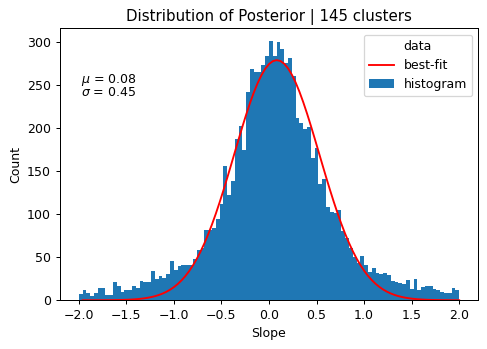

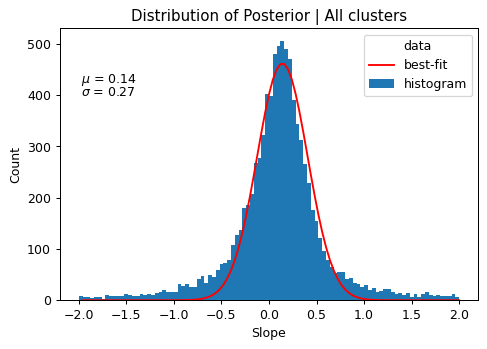

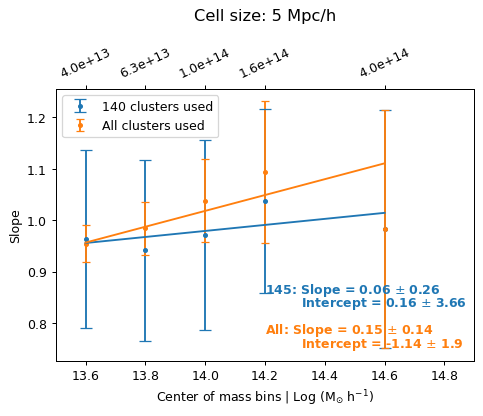

In [56]:
bins_centers_log = np.arange(13.6, 14.21, 0.2)
bins_centers_log = np.append(bins_centers_log, 14.6)


mass_bin_linmix_5000_145 = linmix_func(bins_centers_log, 
                                  clus_mass_bins_results_5000_145['Slope - Vlos'],
                                  clus_mass_bins_results_5000_145['Error - Slope - Vlos'])

plot_posterior(mass_bin_linmix_5000_145, title = '145 clusters')


mass_bin_linmix_5000_all = linmix_func(bins_centers_log, 
                                  clus_mass_bins_results_5000_all['Slope - Vlos'],
                                  clus_mass_bins_results_5000_all['Error - Slope - Vlos'])

plot_posterior(mass_bin_linmix_5000_all, title = 'All clusters')


plt.figure(dpi = dpi)

plt.errorbar(bins_centers_log, 
             clus_mass_bins_results_5000_145['Slope - Vlos'],
             clus_mass_bins_results_5000_145['Error - Slope - Vlos'],
             label = '140 clusters used', capsize = 5, fmt = '.')

plt.errorbar(bins_centers_log, 
             clus_mass_bins_results_5000_all['Slope - Vlos'],
             clus_mass_bins_results_5000_all['Error - Slope - Vlos'],
             label = 'All clusters used', capsize = 3, fmt = '.')

plt.legend()
# plt.xscale('log')
plt.xlabel('Center of mass bins | Log (M$_{\odot}$ h$^{-1}$)')
plt.ylabel('Slope')
plt.xlim(13.5, 14.9)




axes1 = plt.gca()
axes2 = axes1.twiny()

axes2.scatter(bins_centers_log, 
             clus_mass_bins_results_5000_145['Slope - Vlos'], s = 0)
plt.xlim(13.5, 14.9)

bins_centers_linear = 10**bins_centers_log
bins_centers_linear_str = ['{:.1e}'.format(i) for i in bins_centers_linear]

axes2.set_xticks(bins_centers_log)
axes2.set_xticklabels(bins_centers_linear_str, 
                      rotation = 25);


def linear_func(x, m, c):
        return m*x + c


mass_bin_scipy_145 = scipy_curve_fit_func(bins_centers_log, 
                           clus_mass_bins_results_5000_145['Slope - Vlos'],
                           clus_mass_bins_results_5000_145['Error - Slope - Vlos'])


slope_145, intercept_145 = mass_bin_scipy_145[0]
slope_err_145, intercept_err_145 = (np.sqrt(mass_bin_scipy_145[1][0,0]), 
                                   np.sqrt(mass_bin_scipy_145[1][1,1]))


plt.plot(bins_centers_log, 
         linear_func(bins_centers_log, slope_145, intercept_145))

x_pos_text = 0.5
text_font_size = 8

plt.text(x_pos_text, 0.25, 
             f"145: Slope = {round(slope_145, 2)} $\pm$ " + 
             f"{round(slope_err_145, 2)}", 
             transform=plt.gca().transAxes, color = 'C0', weight = 'bold')

plt.text(x_pos_text + 0.085, 0.20, 
             f"Intercept = {round(intercept_145, 2)} $\pm$ " + 
             f"{round(intercept_err_145, 2)}", 
             transform=plt.gca().transAxes, color = 'C0', weight = 'bold')









mass_bin_scipy_all = scipy_curve_fit_func(bins_centers_log, 
                             clus_mass_bins_results_5000_all['Slope - Vlos'],
                             clus_mass_bins_results_5000_all['Error - Slope - Vlos'])

slope_all, intercept_all = mass_bin_scipy_all[0]
slope_err_all, intercept_err_all = (np.sqrt(mass_bin_scipy_all[1][0,0]), 
                                   np.sqrt(mass_bin_scipy_all[1][1,1]))


plt.plot(bins_centers_log, 
         linear_func(bins_centers_log, slope_all, intercept_all))

plt.text(x_pos_text, 0.10, 
             f"All: Slope = {round(slope_all, 2)} $\pm$ " + 
             f"{round(slope_err_all, 2)}", 
             transform=plt.gca().transAxes, color = 'C1', weight = 'bold')

plt.text(x_pos_text + 0.085, 0.05, 
             f"Intercept = {round(intercept_all, 2)} $\pm$ " + 
             f"{round(intercept_err_all, 2)}", 
             transform=plt.gca().transAxes, color = 'C1', weight = 'bold');

plt.title('Cell size: 5 Mpc/h', fontsize = 13, pad = 55);

**14 July, 2021**  
A: It is 3 sigma significant slope.  
A: Since 10 Mpc cells reduces the accuracy of velocity reconstruction, maybe that's why 5 Mpc was preferred in other studies.

**27 July, 2021**  
A: Using smaller cell size increases Poisson error, which increases the error in fit of velocities (2x more here than 10Mpc) (and the error in slope - mass fit). So increasing Poisson error is only reason of disapperance of mass trend? Maybe that's why Tanimura couldn't find it with his 5 Mpc cells.



With 10 Mpc, values are away from 1 because of more smoothing of density field but apparently there is a mass trend as well because most massive guys should have less random component.

In [ ]:
clus_mass_bins_results

### Mass cut: > 10$^{11.25}$ solar masses | b = 2

In [ ]:
clus_mass_bins_results

In [ ]:
clus_mass_bins_results.to_csv(f'clus_mass_bins_results_{greater_than}.csv', sep = '\t')



In [ ]:
cube_cell_size_assess_no_round